In [ ]:
import pandas as pd
import of numpy as np
import tensorflow as tf
import m4atplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Convolution2D , MaxPooling2D , Dense ,Flatten, Dropout , BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder


In [ ]:
df = pd.read_csv('/content/hmnist_28_28_RGB.csv')

# Splits the DataFrame into features (X) and labels (Y).
# X contains all columns except the last one, and Y contains only the last column.
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)

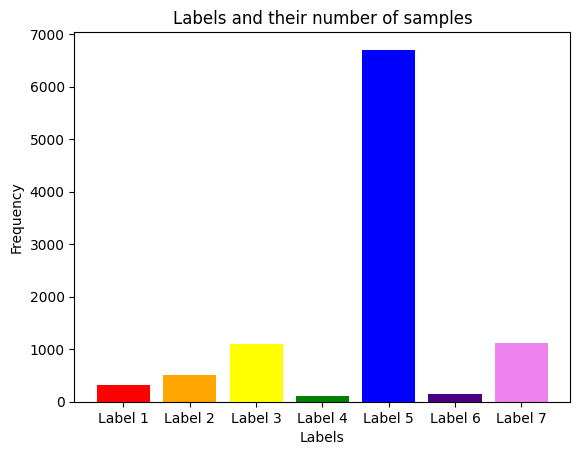

In [ ]:
def printDataBalance(Y):
    data = [0 for _ in range(7)]
    for i in Y:
        data[i] += 1

    # Colors for each bar
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']

    # Create histogram
    plt.bar(range(len(data)), data, color=colors)

    # Adding labels and title
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Labels and their number of samples')

    # Customize x-axis ticks
    plt.xticks(range(len(data)), ['Label {}'.format(i+1) for i in range(len(data))])

printDataBalance(Y)

In [ ]:
oversample = RandomOverSampler(random_state=42)
X, Y  = oversample.fit_resample(X, Y)

X = X.to_numpy()
Y = Y.to_numpy()

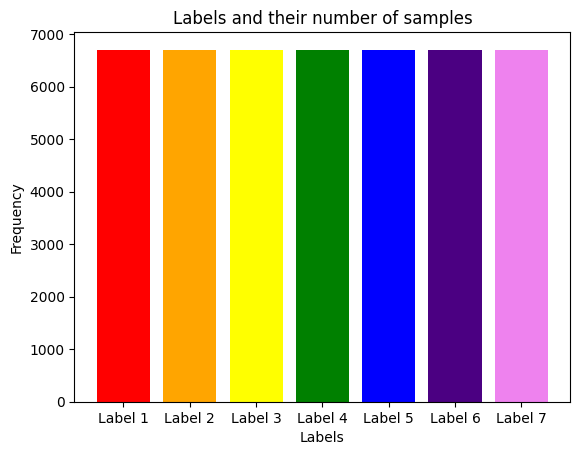

In [ ]:
printDataBalance(Y)

In [ ]:
# Reshapes the features to have a 4D shape
# compatible with convolutional layers (height, width, channels)
# and normalizes the pixel values to be between 0 and 1.

Y = np.reshape(Y ,(46935,1))
X = np.reshape(X , (46935 , 28 , 28, 3))
Actual_X = X
Actual_Y = Y
X = X/256

In [ ]:
# Callback to reducing the learning rate during training if
# monitored metric (val_accuracy in this case) does not improve.

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

early_stopping_callback = EarlyStopping(monitor='val_accuracy',  # Monitor validation accuracy
                                       patience=5,  # Number of epochs with no improvement after which training will be stopped
                                       restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity

In [ ]:
def model_function():
    inputs = Input(shape=(28, 28, 3))
    x = Convolution2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Convolution2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Convolution2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Convolution2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    feature_layer = x  # Extract features before Flatten
    x = Flatten()(x)  # Flatten layer
    x = Dropout(rate=0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(7, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    feature_extractor = Model(inputs=inputs, outputs=feature_layer)  # Extract features before Flatten

    return model, feature_extractor

# Create the model and feature extractor
model, feature_extractor = model_function()

model.summary()

# Load sample data (Replace with actual dataset)
x_sample = np.random.rand(10015, 28, 28, 3)  # Example: 100 images of shape 28x28x3

# Extract features
features = feature_extractor.predict(x_sample)
features = features.reshape(features.shape[0], -1)  # Flatten the features

# Save to CSV
feature_df = pd.DataFrame(features)
feature_df["label"] = y_encoded  # Append labels

feature_df.to_csv("cnn_features.csv", index=False)

print("Feature extraction completed. Saved to cnn_features.csv.")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,208,263 (4.61 MB)

 Trainable params: 1,207,367 (4.61 MB)

 Non-trainable params: 896 (3.50 KB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Feature extraction completed. Saved to cnn_features.csv.


Epoch 1/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.5066 - loss: 1.3047 - val_accuracy: 0.1442 - val_loss: 3.3856 - learning_rate: 0.0010
Epoch 2/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8444 - loss: 0.4347 - val_accuracy: 0.3014 - val_loss: 3.2476 - learning_rate: 0.0010
Epoch 3/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9049 - loss: 0.2591 - val_accuracy: 0.8350 - val_loss: 0.4485 - learning_rate: 0.0010
Epoch 4/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9292 - loss: 0.1950 - val_accuracy: 0.7515 - val_loss: 0.8728 - learning_rate: 0.0010
Epoch 5/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9560 - loss: 0.1240 - val_accuracy: 0.9183 - val_loss: 0.2366 - learning_rate: 0.0010
Epoch 6/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9590 - loss: 0.1159 - val_accuracy: 0.9276 - val_loss: 0.2164 - learning_rate: 0.0010
Epoch 7/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9769 - loss: 0

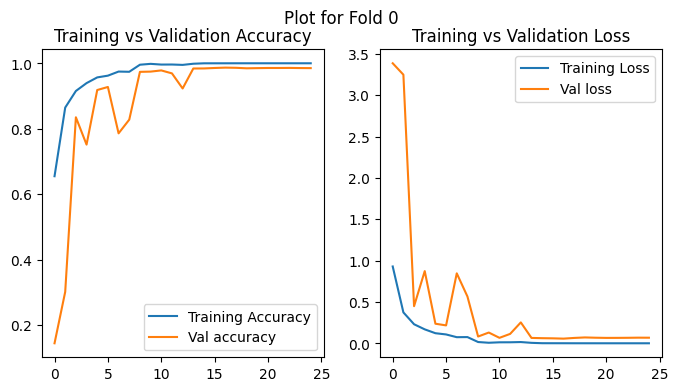

Epoch 1/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.5233 - loss: 1.2916 - val_accuracy: 0.1750 - val_loss: 3.1085 - learning_rate: 0.0010
Epoch 2/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8482 - loss: 0.4157 - val_accuracy: 0.7324 - val_loss: 0.7593 - learning_rate: 0.0010
Epoch 3/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9127 - loss: 0.2381 - val_accuracy: 0.8349 - val_loss: 0.4917 - learning_rate: 0.0010
Epoch 4/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9339 - loss: 0.1819 - val_accuracy: 0.8698 - val_loss: 0.3769 - learning_rate: 0.0010
Epoch 5/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9557 - loss: 0.1226 - val_accuracy: 0.8675 - val_loss: 0.4145 - learning_rate: 0.0010
Epoch 6/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9617 - loss: 0.1089 - val_accuracy: 0.9099 - val_loss: 0.2535 - learning_rate: 0.0010
Epoch 7/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9706 - loss: 0

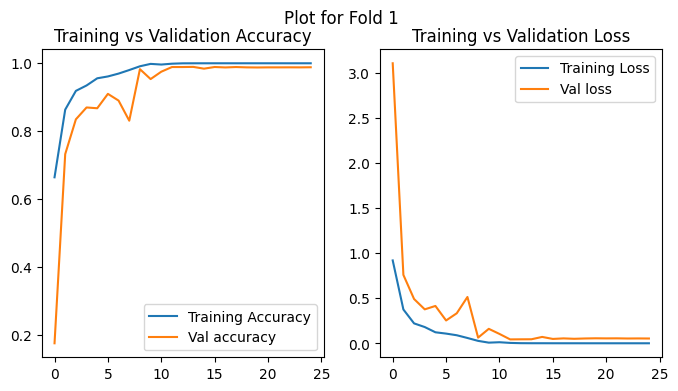

Epoch 1/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.4706 - loss: 1.4538 - val_accuracy: 0.1374 - val_loss: 3.0440 - learning_rate: 0.0010
Epoch 2/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8300 - loss: 0.4653 - val_accuracy: 0.5328 - val_loss: 1.4754 - learning_rate: 0.0010
Epoch 3/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9046 - loss: 0.2630 - val_accuracy: 0.8803 - val_loss: 0.3074 - learning_rate: 0.0010
Epoch 4/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9365 - loss: 0.1757 - val_accuracy: 0.8515 - val_loss: 0.4155 - learning_rate: 0.0010
Epoch 5/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9493 - loss: 0.1415 - val_accuracy: 0.9340 - val_loss: 0.2061 - learning_rate: 0.0010
Epoch 6/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9674 - loss: 0.0942 - val_accuracy: 0.7257 - val_loss: 0.9057 - learning_rate: 0.0010
Epoch 7/25
292/294 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9683 - loss: 0

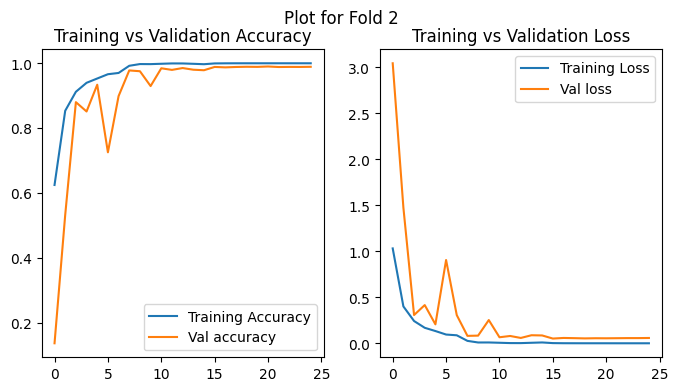

Epoch 1/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.5129 - loss: 1.3420 - val_accuracy: 0.1438 - val_loss: 3.6745 - learning_rate: 0.0010
Epoch 2/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8391 - loss: 0.4455 - val_accuracy: 0.5943 - val_loss: 1.2700 - learning_rate: 0.0010
Epoch 3/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9130 - loss: 0.2402 - val_accuracy: 0.7899 - val_loss: 0.6301 - learning_rate: 0.0010
Epoch 4/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9302 - loss: 0.1888 - val_accuracy: 0.8281 - val_loss: 0.5923 - learning_rate: 0.0010
Epoch 5/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9553 - loss: 0.1273 - val_accuracy: 0.8971 - val_loss: 0.3080 - learning_rate: 0.0010
Epoch 6/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9664 - loss: 0.0969 - val_accuracy: 0.8708 - val_loss: 0.4421 - learning_rate: 0.0010
Epoch 7/25
291/294 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9725 - loss: 

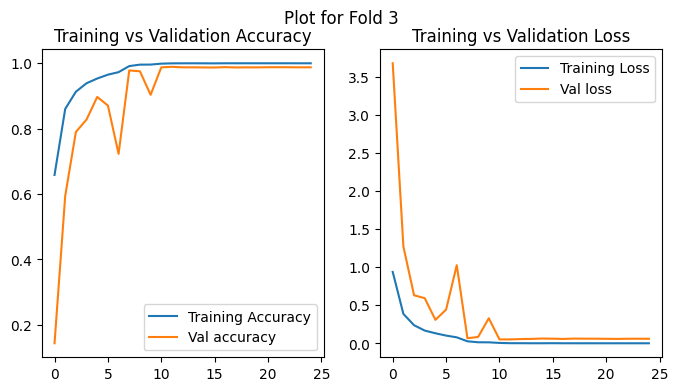

Epoch 1/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.5522 - loss: 1.2225 - val_accuracy: 0.2033 - val_loss: 2.7710 - learning_rate: 0.0010
Epoch 2/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8500 - loss: 0.4096 - val_accuracy: 0.6434 - val_loss: 1.0451 - learning_rate: 0.0010
Epoch 3/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9135 - loss: 0.2452 - val_accuracy: 0.7477 - val_loss: 0.7911 - learning_rate: 0.0010
Epoch 4/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9464 - loss: 0.1550 - val_accuracy: 0.8476 - val_loss: 0.4599 - learning_rate: 0.0010
Epoch 5/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9533 - loss: 0.1322 - val_accuracy: 0.7986 - val_loss: 0.6981 - learning_rate: 0.0010
Epoch 6/25
292/294 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9708 - loss: 0.0845
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9707 - loss: 0.

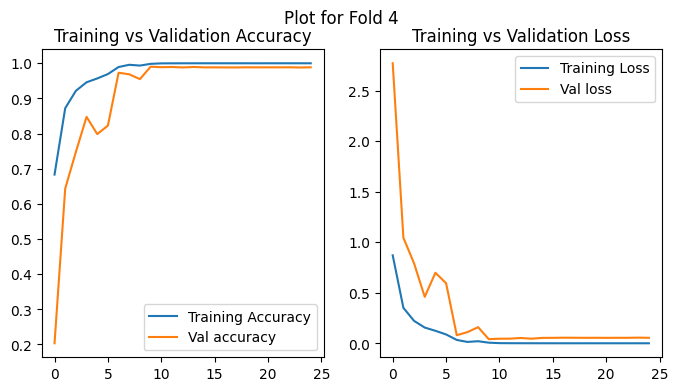

Average Accuracy: 0.9730243945121765


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
i = 0

for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model, feature_extractor = model_function()

    # Train the model
    fitting_stats = model.fit(X_train , y_train , epochs = 25 , batch_size=128 , validation_data=(X_test , y_test),
              callbacks=[learning_rate_reduction])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy}")

    acc = fitting_stats.history['accuracy']
    val_acc = fitting_stats.history['val_accuracy']

    loss = fitting_stats.history['loss']
    val_loss = fitting_stats.history['val_loss']


    plt.figure(figsize=(8,4))

    plt.subplot(1 , 2 , 1 )
    plt.plot(range(25) , acc , label="Training Accuracy")
    plt.plot(range(25) , val_acc , label="Val accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend(loc="lower right")


    plt.subplot(1 , 2 , 2 )
    plt.plot(range(25) , loss  , label="Training Loss")
    plt.plot(range(25) , val_loss , label="Val loss")
    plt.title("Training vs Validation Loss")
    plt.legend(loc="upper right")
    plt.suptitle('Plot for Fold '+ str(i) )
    plt.show()
    i = i+1


average = sum(acc) / len(acc)
print("Average Accuracy:", average)